In [12]:
# Tobacco Use & Mortality ML Pipeline — Single Jupyter Cell
# All plots render inline in .ipynb (no images saved/downloaded)
# Replace the file paths below if different

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import pickle
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Utility function
def clean_and_normalize_year(df, year_col):
    """
    Convert fiscal-like string years ('2014/15') or numeric years to integer start-year.
    Drops rows where conversion fails.
    Returns copy with column 'Year_Key' (int).
    """
    dfc = df.copy()
    def get_start_year(y):
        if pd.isna(y):
            return np.nan
        try:
            s = str(y).strip()
            if '/' in s:
                return int(s.split('/')[0])
            else:
                return int(float(s))
        except Exception:
            return np.nan
    dfc['Year_Key'] = dfc[year_col].apply(get_start_year)
    dfc = dfc.dropna(subset=['Year_Key'])
    dfc['Year_Key'] = dfc['Year_Key'].astype(int)
    # drop original year column if present
    if year_col in dfc.columns:
        try:
            dfc = dfc.drop(columns=[year_col])
        except Exception:
            pass
    return dfc

# 1. FILE PATHS (update if needed)
path_admissions    = "/content/admissions.csv"     # admissions dataset
path_fatalities    = "/content/fatalities.csv"     # fatalities (target)
path_metrics       = "/content/metrics.csv"        # economic metrics
path_prescriptions = "/content/prescriptions.csv"  # cessation prescriptions
path_smokers       = "/content/smokers.csv"        # prevalence


In [13]:
# 2. LOAD DATAFRAMES (with safety checks)
print("Loading CSV files...")
dfs = {}
for name, path in [("admissions", path_admissions),
                   ("fatalities", path_fatalities),
                   ("metrics", path_metrics),
                   ("prescriptions", path_prescriptions),
                   ("smokers", path_smokers)]:
    try:
        dfs[name] = pd.read_csv(path)
        print(f"  Loaded {name}: {dfs[name].shape}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find '{path}'. Please upload the file to that path before running.")
    except Exception as e:
        raise RuntimeError(f"Error loading {path}: {e}")

Loading CSV files...
  Loaded admissions: (2079, 7)
  Loaded fatalities: (1749, 7)
  Loaded metrics: (36, 9)
  Loaded prescriptions: (11, 9)
  Loaded smokers: (84, 9)


In [14]:
# 3. CLEAN & NORMALIZE YEAR COLUMNS
# The function will drop rows where Year couldn't be parsed
dfs['admissions']    = clean_and_normalize_year(dfs['admissions'], 'Year')
dfs['fatalities']    = clean_and_normalize_year(dfs['fatalities'], 'Year')
dfs['metrics']       = clean_and_normalize_year(dfs['metrics'], 'Year')
dfs['prescriptions'] = clean_and_normalize_year(dfs['prescriptions'], 'Year')
dfs['smokers']       = clean_and_normalize_year(dfs['smokers'], 'Year')

In [15]:
# 4. PREPARE individual datasets (select/rename expected fields)
# A) Admissions: filter attributable admissions to smoking if columns exist
ad = dfs['admissions'].copy()
if {'Diagnosis Type','Metric','Value','Year_Key'}.issubset(ad.columns):
    admissions_total = ad[
        (ad['Diagnosis Type'].str.strip().str.lower() == 'all diseases which can be caused by smoking') &
        (ad['Metric'].str.strip().str.lower() == 'attributable number')
    ].groupby('Year_Key')['Value'].sum().reset_index().rename(columns={'Value': 'Smoking_Attributed_Admissions'})
else:
    # fallback: aggregate any numeric 'Value' by Year_Key
    numeric_cols = [c for c in ad.columns if pd.api.types.is_numeric_dtype(ad[c])]
    if 'Value' in ad.columns:
        admissions_total = ad.groupby('Year_Key')['Value'].sum().reset_index().rename(columns={'Value': 'Smoking_Attributed_Admissions'})
    elif numeric_cols:
        admissions_total = ad.groupby('Year_Key')[numeric_cols[0]].sum().reset_index().rename(columns={numeric_cols[0]: 'Smoking_Attributed_Admissions'})
    else:
        admissions_total = pd.DataFrame(columns=['Year_Key','Smoking_Attributed_Admissions'])

# B) Fatalities: build totals and attributable counts
fa = dfs['fatalities'].copy()
# attempt to pivot using known columns; otherwise sum numeric fields by Year_Key
if {'Diagnosis Type','Metric','Value','Year_Key'}.issubset(fa.columns):
    # pivot two-layer as in original
    pivot = fa.groupby(['Year_Key','Diagnosis Type','Metric'])['Value'].sum().unstack(fill_value=np.nan).unstack(fill_value=np.nan)
    # attempt safe extraction using string matching
    # Create fallback aggregated Series
    try:
        total_deaths = fa[fa['Metric'].str.contains('Number', case=False, na=False) & fa['Diagnosis Type'].str.contains('All deaths', case=False, na=False)]
        total_deaths = total_deaths.groupby('Year_Key')['Value'].sum().reset_index().rename(columns={'Value':'Total_Observed_Deaths'})
    except Exception:
        total_deaths = fa.groupby('Year_Key')['Value'].sum().reset_index().rename(columns={'Value':'Total_Observed_Deaths'})
    try:
        attr = fa[fa['Metric'].str.contains('Attributable', case=False, na=False) & fa['Diagnosis Type'].str.contains('can be caused by smoking', case=False, na=False)]
        attr = attr.groupby('Year_Key')['Value'].sum().reset_index().rename(columns={'Value':'Smoking_Attributed_Fatalities'})
    except Exception:
        # best-effort: look for any rows mentioning 'attribut' or 'smoking'
        cond = fa['Metric'].str.contains('attribut', case=False, na=False) | fa['Diagnosis Type'].str.contains('smoking', case=False, na=False)
        attr = fa[cond].groupby('Year_Key')['Value'].sum().reset_index().rename(columns={'Value':'Smoking_Attributed_Fatalities'})
else:
    # fallback global numeric sums
    numeric_cols_fa = [c for c in fa.columns if pd.api.types.is_numeric_dtype(fa[c])]
    if numeric_cols_fa:
        total_deaths = fa.groupby('Year_Key')[numeric_cols_fa[0]].sum().reset_index().rename(columns={numeric_cols_fa[0]:'Total_Observed_Deaths'})
        # treat second numeric (if exists) as attributable
        if len(numeric_cols_fa) > 1:
            attr = fa.groupby('Year_Key')[numeric_cols_fa[1]].sum().reset_index().rename(columns={numeric_cols_fa[1]:'Smoking_Attributed_Fatalities'})
        else:
            attr = fa.groupby('Year_Key')[numeric_cols_fa[0]].sum().reset_index().rename(columns={numeric_cols_fa[0]:'Smoking_Attributed_Fatalities'})
    else:
        total_deaths = pd.DataFrame(columns=['Year_Key','Total_Observed_Deaths'])
        attr = pd.DataFrame(columns=['Year_Key','Smoking_Attributed_Fatalities'])

# Merge fatalities summary
df_target = pd.merge(total_deaths, attr, on='Year_Key', how='inner')

# C) Metrics: select the likely columns (with fallback)
met = dfs['metrics'].copy()
# Normalize expected column names
met.columns = [c.strip() for c in met.columns]
rename_map = {}
for col in met.columns:
    low = col.lower()
    if 'tobacco price' in low:
        rename_map[col] = 'Tobacco_Price_Index'
    if 'affordab' in low:
        rename_map[col] = 'Affordability_Index'
    if 'expenditure' in low and 'tobacco' in low:
        rename_map[col] = 'Tobacco_Expenditure_Ratio'
met = met.rename(columns=rename_map)
metrics_cols = ['Year_Key','Tobacco_Price_Index','Affordability_Index','Tobacco_Expenditure_Ratio']
available_metrics = [c for c in metrics_cols if c in met.columns]
if 'Year_Key' not in met.columns and 'Year_Key' in dfs['metrics'].columns:
    met = dfs['metrics']  # fallback earlier
metrics_sel = met[[c for c in available_metrics]].copy() if available_metrics else pd.DataFrame(columns=metrics_cols)

# D) Prescriptions: expect 'All Pharmacotherapy Prescriptions' or similar
pr = dfs['prescriptions'].copy()
pr_cols = [c for c in pr.columns if 'prescript' in c.lower() or 'pharmacotherapy' in c.lower() or 'cessation' in c.lower() or 'total' in c.lower()]
if pr_cols:
    pr = pr.rename(columns={pr_cols[0]:'Total_Cessation_Prescriptions'})
    prescriptions_sel = pr[['Year_Key','Total_Cessation_Prescriptions']].copy()
    # normalize to thousands if large
    prescriptions_sel['Total_Cessation_Prescriptions_K'] = prescriptions_sel['Total_Cessation_Prescriptions'] / 1000.0
    prescriptions_sel = prescriptions_sel[['Year_Key','Total_Cessation_Prescriptions_K']]
else:
    prescriptions_sel = pd.DataFrame(columns=['Year_Key','Total_Cessation_Prescriptions_K'])

# E) Smokers prevalence: expect column '16 and Over' or similar
sm = dfs['smokers'].copy()
sm_cols = [c for c in sm.columns if '16' in c or '16 and' in c.lower() or 'prevalence' in c.lower() or '%' in c]
if sm_cols:
    smokers_sel = sm[['Year_Key', sm_cols[0]]].rename(columns={sm_cols[0]:'Smoking_Prevalence_Rate'}).copy()
else:
    # try columns named 'Value' or 'Prevalence'
    if 'Value' in sm.columns:
        smokers_sel = sm[['Year_Key','Value']].rename(columns={'Value':'Smoking_Prevalence_Rate'}).copy()
    elif 'Prevalence' in sm.columns:
        smokers_sel = sm[['Year_Key','Prevalence']].rename(columns={'Prevalence':'Smoking_Prevalence_Rate'}).copy()
    else:
        smokers_sel = pd.DataFrame(columns=['Year_Key','Smoking_Prevalence_Rate'])

# Ensure numeric types for key aggregated tables
for df_ in [admissions_total, df_target, metrics_sel, prescriptions_sel, smokers_sel]:
    for c in df_.columns:
        if c != 'Year_Key':
            try:
                df_[c] = pd.to_numeric(df_[c], errors='coerce')
            except Exception:
                pass

In [16]:
# 5. MERGE ALL SOURCES ON Year_Key
# Start with fatalities target (must exist)
if df_target.empty:
    raise RuntimeError("Fatalities/target data could not be parsed — ensure fatalities CSV has Year, Diagnosis Type, Metric, Value columns.")

df_final = df_target.copy()

# merge function with inner join to keep only years present across datasets
def safe_merge(left, right, on='Year_Key', how='inner'):
    if right.empty:
        return left
    return pd.merge(left, right, on=on, how=how)

df_final = safe_merge(df_final, admissions_total, on='Year_Key', how='inner')
df_final = safe_merge(df_final, metrics_sel, on='Year_Key', how='inner')
df_final = safe_merge(df_final, prescriptions_sel, on='Year_Key', how='inner')
df_final = safe_merge(df_final, smokers_sel, on='Year_Key', how='inner')

# If any expected columns are missing, fill with NaN (they will be dropped later)
expected_cols = ['Smoking_Attributed_Admissions','Tobacco_Price_Index','Affordability_Index',
                 'Tobacco_Expenditure_Ratio','Total_Cessation_Prescriptions_K','Smoking_Prevalence_Rate']
for c in expected_cols:
    if c not in df_final.columns:
        df_final[c] = np.nan

# Drop rows with critical NaNs (we need fatalities and observed deaths)
df_final = df_final.dropna(subset=['Total_Observed_Deaths','Smoking_Attributed_Fatalities'])

# Convert admissions to thousands if not already
if 'Smoking_Attributed_Admissions' in df_final.columns and df_final['Smoking_Attributed_Admissions'].mean() > 1000:
    df_final['Smoking_Attributed_Admissions_K'] = df_final['Smoking_Attributed_Admissions'] / 1000.0
else:
    df_final['Smoking_Attributed_Admissions_K'] = df_final.get('Smoking_Attributed_Admissions', pd.Series(0, index=df_final.index)) / 1000.0

In [17]:
# 6. FEATURE ENGINEERING & TARGET CREATION
df_final['Smoking_Mortality_Rate'] = (df_final['Smoking_Attributed_Fatalities'] / df_final['Total_Observed_Deaths']) * 1000.0

# Create binary target using median threshold
median_rate = df_final['Smoking_Mortality_Rate'].median()
df_final['High_Mortality_Risk'] = (df_final['Smoking_Mortality_Rate'] > median_rate).astype(int)

# Select features (drop identifiers and target-related leakage columns)
drop_cols = ['Smoking_Attributed_Fatalities','Total_Observed_Deaths','Smoking_Mortality_Rate']
features = [c for c in df_final.columns if c not in drop_cols + ['Year_Key','High_Mortality_Risk']]
# Keep only numeric features (classifier needs numeric input; if categorical exist consider encoding)
X = df_final[features].select_dtypes(include=[np.number]).fillna(0)  # fill small NaNs with 0 for modeling
y = df_final['High_Mortality_Risk']

print("\nFinal dataset years:", df_final['Year_Key'].tolist())
print("Feature columns used:", list(X.columns))
print("Target distribution:\n", y.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("-" * 60)


Final dataset years: [2004, 2004, 2004, 2005, 2005, 2005, 2006, 2006, 2006, 2007, 2007, 2007, 2008, 2008, 2008, 2009, 2009, 2009, 2010, 2010, 2010, 2011, 2011, 2011, 2012, 2012, 2012, 2013, 2013, 2013, 2014, 2014, 2014]
Feature columns used: ['Tobacco_Price_Index', 'Tobacco_Price_Index', 'Tobacco_Price_Index', 'Tobacco_Price_Index', 'Affordability_Index', 'Tobacco_Expenditure_Ratio', 'Tobacco_Expenditure_Ratio', 'Tobacco_Expenditure_Ratio', 'Tobacco_Expenditure_Ratio', 'Total_Cessation_Prescriptions_K', 'Smoking_Prevalence_Rate', 'Smoking_Attributed_Admissions', 'Smoking_Attributed_Admissions_K']
Target distribution:
 High_Mortality_Risk
0    54.5%
1    45.5%
Name: proportion, dtype: object
------------------------------------------------------------


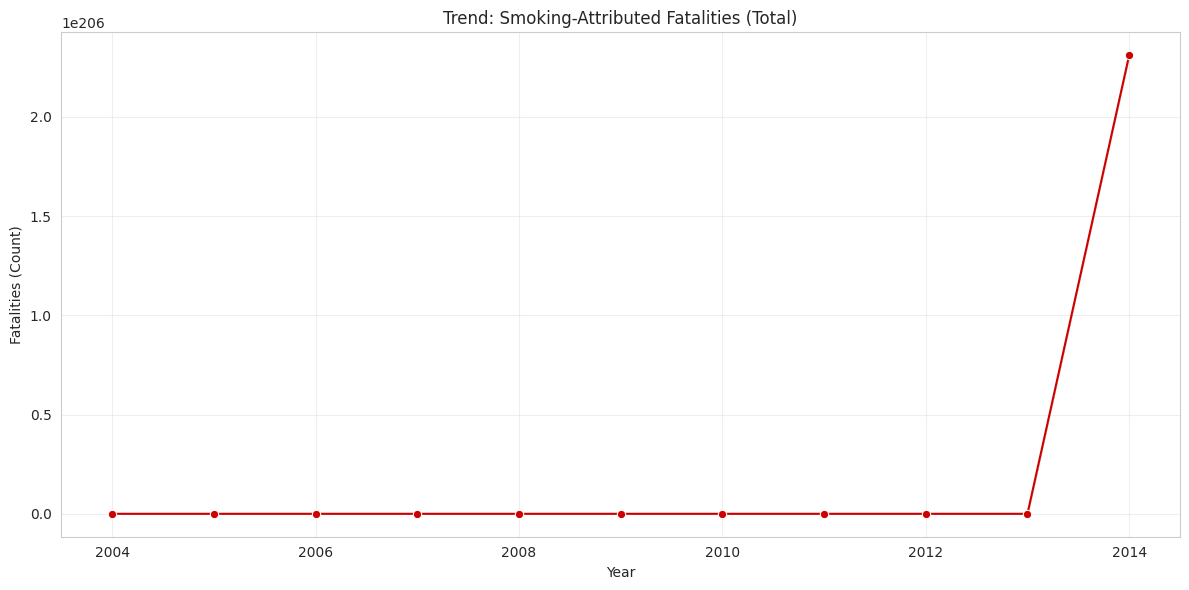

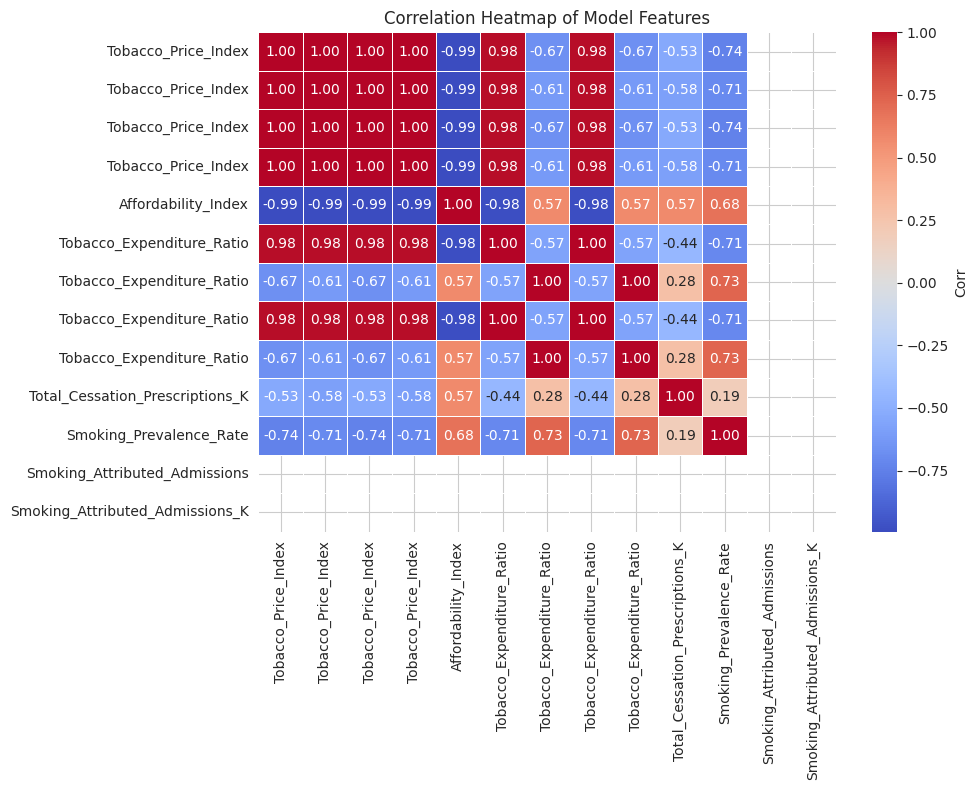

In [18]:
# 7. EDA PLOTS (inline)
# 1) Time series of attributable fatalities
plt.figure(figsize=(12,6))
sns.lineplot(x='Year_Key', y='Smoking_Attributed_Fatalities', data=df_final, marker='o', color='#cc0000')
plt.title('Trend: Smoking-Attributed Fatalities (Total)')
plt.xlabel('Year')
plt.ylabel('Fatalities (Count)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Correlation heatmap of numeric features
if X.shape[1] > 0:
    plt.figure(figsize=(10,8))
    sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar_kws={'label':'Corr'})
    plt.title('Correlation Heatmap of Model Features')
    plt.tight_layout()
    plt.show()
else:
    print("No numeric features available for correlation heatmap.")

In [19]:
# 8. MODEL TRAIN/TEST, TRAINING & EVALUATION
# If dataset is tiny (few years), stratify may fail. Wrap with try/except.
test_size = 0.3
if y.nunique() < 2:
    raise RuntimeError("Target variable has <2 classes after processing — can't train classifier.")
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
except Exception:
    # fallback to no stratify
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=None)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Predictions and probabilities
y_pred = rf_clf.predict(X_test_scaled)
y_proba = rf_clf.predict_proba(X_test_scaled)[:,1] if hasattr(rf_clf, "predict_proba") else None

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

print("\n--- Model Evaluation (Random Forest) ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")
print("-" * 60)



--- Model Evaluation (Random Forest) ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000
ROC-AUC  : 1.0000
------------------------------------------------------------


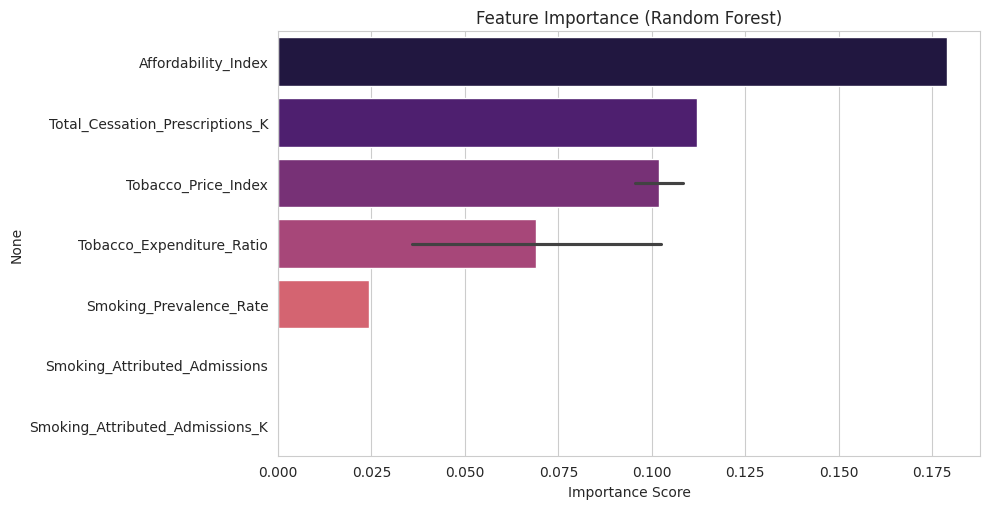

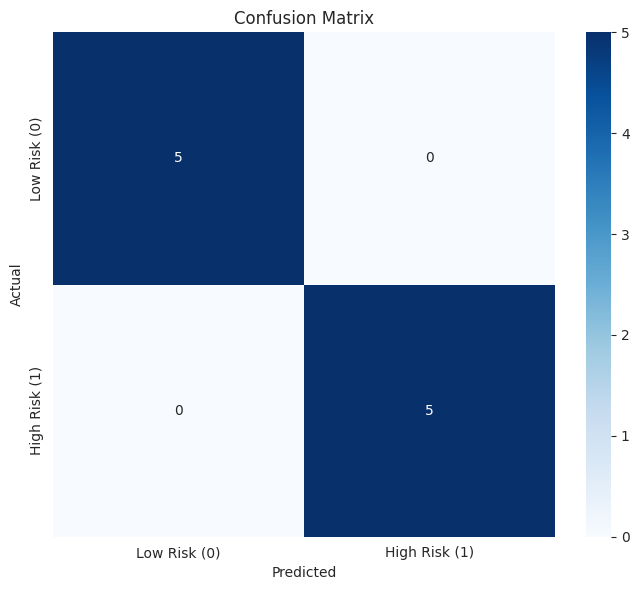

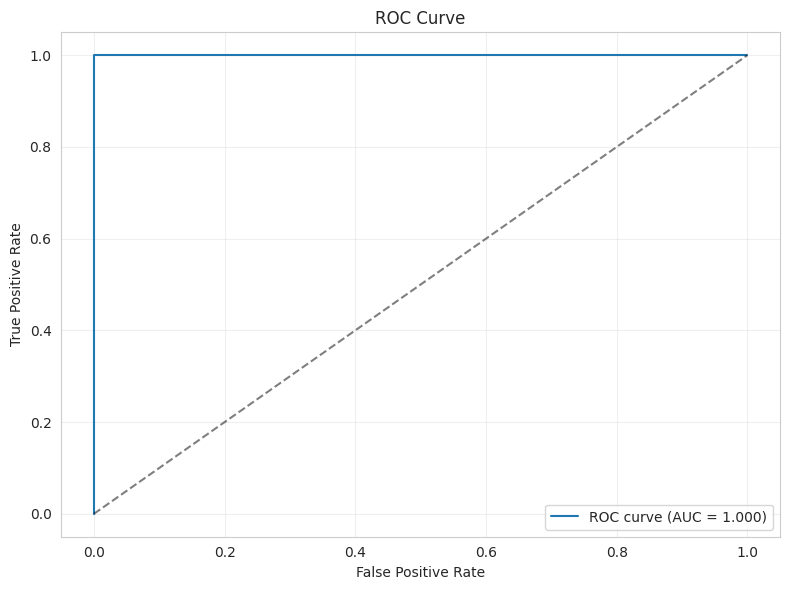

In [20]:
# 9. INTERPRETATION & PLOTS (inline)
# Feature importances
feat_importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, max(4, 0.4*len(feat_importances))))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='magma')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk (0)', 'High Risk (1)'],
            yticklabels=['Low Risk (0)', 'High Risk (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Optional: ROC curve if probabilities available
if y_proba is not None:
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
    plt.plot([0,1],[0,1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [21]:
# 10. SAVE ARTIFACTS (optional)
# Save model and scaler for later use (uncomment if desired)
with open('/content/rf_tobacco_mortality_model.pkl', 'wb') as f:
    pickle.dump({'model': rf_clf, 'scaler': scaler, 'features': list(X.columns)}, f)
print("Model + scaler saved to /content/rf_tobacco_mortality_model.pkl")

# 11. SHORT SUMMARY PRINT
print("\nSummary:")
print(f"Years used: {df_final['Year_Key'].min()} - {df_final['Year_Key'].max()}")
print(f"Rows (years) in final dataset: {df_final.shape[0]}")
print(f"Features used: {len(X.columns)}")
print("Note: Inspect the printed feature list and ensure the domain columns (metrics, prevalence) were parsed correctly from CSVs.")

Model + scaler saved to /content/rf_tobacco_mortality_model.pkl

Summary:
Years used: 2004 - 2014
Rows (years) in final dataset: 33
Features used: 13
Note: Inspect the printed feature list and ensure the domain columns (metrics, prevalence) were parsed correctly from CSVs.
